<a href="https://colab.research.google.com/github/phelipe-sb/Rain-Prediction/blob/main/Exploratory_Analisis_and_Data_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Get Data from BigQuery**

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import pandas as pd

In [ ]:
# Projett credentials with account service
path = '/content/drive/MyDrive/Weather_Project/Weather Project-6fa8e059f642.json'

In [ ]:
# Credentials
credentials = service_account.Credentials.from_service_account_file(path)
project_id = credentials.project_id
client = bigquery.Client(project=project_id, credentials=credentials)

In [ ]:
# SQL Query that will run in BQ
query_string = """
SELECT *
FROM (SELECT *
            , ROW_NUMBER() OVER(PARTITION BY last_updated, city ORDER BY last_updated, city) AS row_num
            FROM `weather-project-305419.Daily_Weather.Weather-Info`) as row_weather
WHERE row_num = 1
"""

In [ ]:
# Transform sql query results in a pandas dataframe
df = (
    client.query(query_string)
    .result()
    .to_dataframe()
)
df.head()

,last_updated_epoch,last_updated,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,city,extraction_date,row_num
0,1619162100,2021-04-23 04:15,16.4,61.5,0,Partly cloudy,4.7,7.6,144,SE,1018.0,30.5,0.1,0.0,89,53,16.4,61.5,10.0,6.0,1.0,5.4,8.6,Sao Paulo,None,1
1,1619256600,2021-04-24 05:30,11.7,53.1,0,Clear,9.4,15.1,310,NW,1016.0,30.5,0.0,0.0,36,0,10.1,50.1,16.0,9.0,1.0,13.4,21.6,New York,None,1
2,1619326800,2021-04-25 02:00,18.8,65.8,0,Partly cloudy,2.5,4.0,99,E,1014.0,30.4,0.0,0.0,90,24,18.8,65.8,10.0,6.0,1.0,3.8,6.1,Carapicuiba,None,1
3,1619506800,2021-04-27 04:00,16.6,61.9,0,Light rain shower,5.6,9.0,123,ESE,1015.0,30.4,0.2,0.01,90,85,16.6,61.9,10.0,6.0,1.0,8.5,13.7,Carapicuiba,None,1
4,1619541900,2021-04-27 12:45,13.9,57.0,1,Partly cloudy,0.0,0.0,0,N,1019.0,30.6,0.1,0.0,23,75,13.7,56.7,16.0,9.0,4.0,5.1,8.3,New York,None,1


In [ ]:
%cd /content/drive/MyDrive/Weather_Project

/content/drive/MyDrive/Weather_Project


In [ ]:
# Saving in a pickle file so we don't need query in database again
import pickle
df.to_pickle("weather_data")

### **2. Data Transformation**

In [ ]:
# Open pickle file
file = open('/content/drive/MyDrive/Weather_Project/weather_data', 'rb')
df = pickle.load(file)

In [ ]:
cidades = ['Paris', 'Sao Paulo', 'Carapicuiba', 'New York', 'Otawwa', 'London', 'Rome', 'Moscow'
        , 'Hong Kong', 'Beijing']
df = df.loc[df['city'].isin(cidades)]
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.shape

(58400, 26)

In [ ]:
# Drop useless columns for analysis
df = df.drop(columns=['row_num', 'last_updated_epoch', 'extraction_date'])
df = df.dropna()
# number of rows and columns
print(df.shape, df['city'].unique())

(58400, 23) ['Sao Paulo' 'New York' 'Carapicuiba' 'Paris' 'Hong Kong' 'Moscow' 'Rome'
 'London' 'Beijing']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Target: Predict condition (that means wether is raining or not) 
df['condition'].unique()

array(['Partly cloudy', 'Clear', 'Light rain shower', 'Cloudy', 'Sunny',
       'Mist', 'Overcast', 'Patchy rain possible', 'Light rain',
       'Moderate or heavy rain shower', 'Patchy light rain with thunder',
       'Thundery outbreaks possible', 'Light drizzle',
       'Moderate rain at times', 'Torrential rain shower', 'Heavy rain',
       'Fog', 'Moderate rain', 'Patchy light rain', 'Light snow',
       'Moderate or heavy rain with thunder',
       'Moderate or heavy snow with thunder',
       'Moderate or heavy snow showers', 'Heavy rain at times',
       'Ice pellets'], dtype=object)

We need to resume this bunch of conditions and define our target class

In [ ]:
# This conditions means that it's raining in the moment
raining_list = ['Light rain', 'Light rain shower', 'Light drizzle', 'Heavy rain', 'Moderate rain', 'Patchy light rain with thunder'
            , 'Moderate or heavy rain shower', 'Patchy light rain', 'Torrential rain shower', 'Moderate rain at times'
            , 'Moderate or heavy rain with thunder']

In [ ]:
# Creating the target variable
df['target'] = df['condition'].apply(lambda x: 1 if x in raining_list else 0)
df['target'].unique()

array([0, 1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58400 entries, 0 to 60821
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  58400 non-null  datetime64[ns]
 1   temp_c        58400 non-null  object        
 2   temp_f        58400 non-null  object        
 3   is_day        58400 non-null  object        
 4   condition     58400 non-null  object        
 5   wind_mph      58400 non-null  object        
 6   wind_kph      58400 non-null  object        
 7   wind_degree   58400 non-null  object        
 8   wind_dir      58400 non-null  object        
 9   pressure_mb   58400 non-null  object        
 10  pressure_in   58400 non-null  object        
 11  precip_mm     58400 non-null  object        
 12  precip_in     58400 non-null  object        
 13  humidity      58400 non-null  object        
 14  cloud         58400 non-null  object        
 15  feelslike_c   58400 non-null  object

In [ ]:
# Create a list with columns to be converted
float_list = list()
for column_name in df.drop(columns='target').columns:
  if str(df[f'{column_name}'][0]).replace(".", "").replace("-", "").isnumeric() == True:
    float_list.append(column_name)

In [ ]:
# function to convert columns to float
def to_float(df):
  for column in df.columns:
    if column in float_list:
      df[f'{column}'] = df[f'{column}'].astype("float")
  return df.info()

In [ ]:
to_float(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58400 entries, 0 to 60821
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   last_updated  58400 non-null  datetime64[ns]
 1   temp_c        58400 non-null  float64       
 2   temp_f        58400 non-null  float64       
 3   is_day        58400 non-null  float64       
 4   condition     58400 non-null  object        
 5   wind_mph      58400 non-null  float64       
 6   wind_kph      58400 non-null  float64       
 7   wind_degree   58400 non-null  float64       
 8   wind_dir      58400 non-null  object        
 9   pressure_mb   58400 non-null  float64       
 10  pressure_in   58400 non-null  float64       
 11  precip_mm     58400 non-null  float64       
 12  precip_in     58400 non-null  float64       
 13  humidity      58400 non-null  float64       
 14  cloud         58400 non-null  float64       
 15  feelslike_c   58400 non-null  float6

### **3. Data Analysis**

percentage of target == 1 is: 10.0%


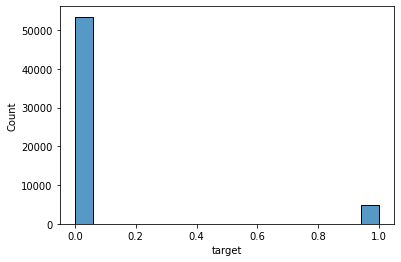

In [ ]:
# Target Variable Ocurrency
percent = str(round(sum(df['target'])/len(df['target']), 1)*100) + '%'
print(f'percentage of target == 1 is: {percent}')
sns.histplot(data=df['target'])

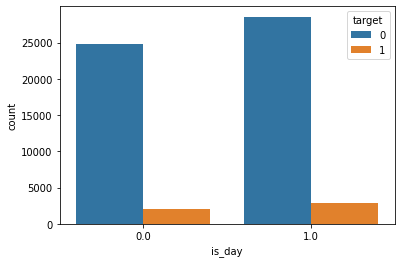

In [ ]:
sns.countplot(x=df['is_day'], hue=df['target'])

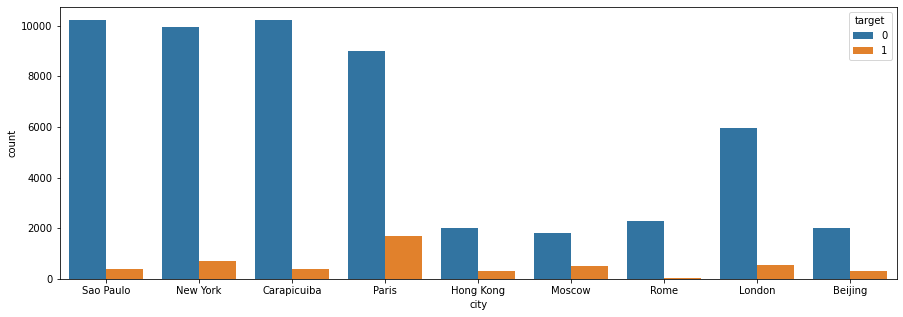

In [ ]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=df['city'], hue=df['target'])

<Figure size 720x360 with 0 Axes>

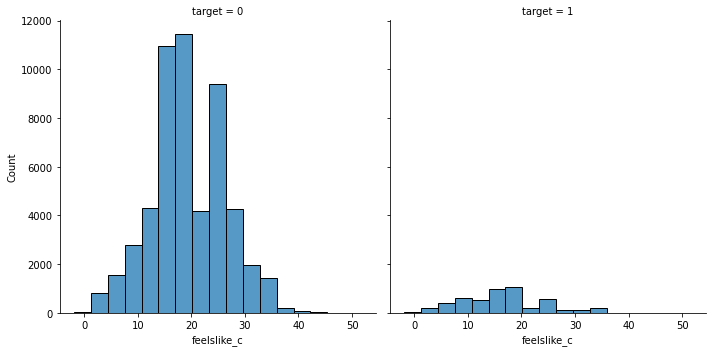

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['feelslike_c'], bins='sturges', col=df['target'])

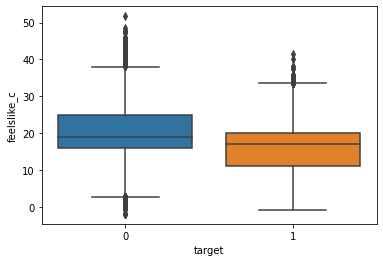

In [ ]:
sns.boxplot(x=df['target'], y=df['feelslike_c'])

<Figure size 720x360 with 0 Axes>

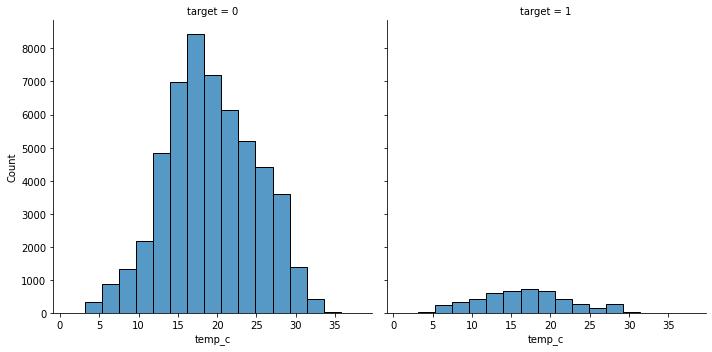

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['temp_c'], bins='sturges', col=df['target'])

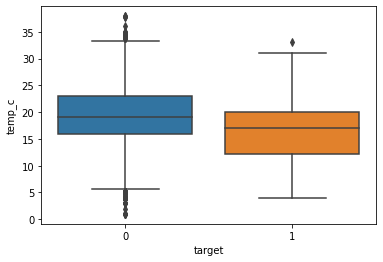

In [ ]:
sns.boxplot(x=df['target'], y=df['temp_c'])

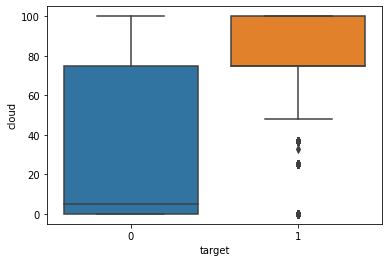

In [ ]:
sns.boxplot(x=df['target'], y=df['cloud'])

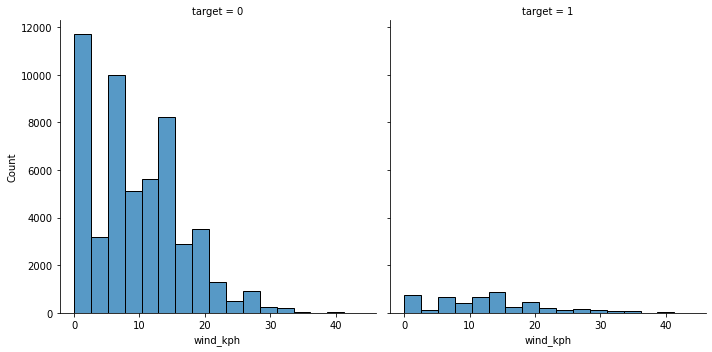

In [ ]:
sns.displot(x=df['wind_kph'], col=df['target'], bins='sturges')

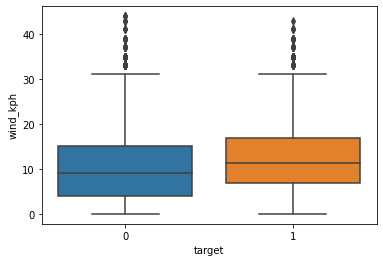

In [ ]:
sns.boxplot(x=df['target'], y=df['wind_kph'])

In [ ]:
df.describe()

,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,target
count,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000,58400.00000,58400.000000,58400.000000,58400.000000,58400.000000,58400.000000
mean,19.063310,66.314146,0.538048,5.994967,9.640839,156.097380,1017.416250,30.283768,0.272781,0.010547,69.117158,35.947277,19.306808,66.748110,10.38876,6.071644,3.328390,9.057753,14.575875,0.084949
std,5.739728,10.331593,0.498555,4.557210,7.342580,104.012014,6.066545,0.309883,1.563741,0.061608,18.131422,38.556197,6.924451,12.464305,2.77661,1.611606,2.448204,4.650639,7.484540,0.278808
min,1.000000,33.800000,0.000000,0.000000,0.000000,0.000000,994.000000,29.380000,0.000000,0.000000,8.000000,0.000000,-1.900000,28.700000,0.00000,0.000000,1.000000,0.200000,0.400000,0.000000
25%,15.000000,59.000000,0.000000,2.500000,4.000000,74.000000,1014.000000,30.030000,0.000000,0.000000,57.000000,0.000000,15.500000,59.900000,10.00000,6.000000,1.000000,5.600000,9.000000,0.000000
50%,19.000000,66.200000,1.000000,5.600000,9.000000,140.000000,1018.000000,30.240000,0.000000,0.000000,73.000000,25.000000,19.000000,66.200000,10.00000,6.000000,3.000000,8.500000,13.700000,0.000000
75%,23.000000,73.400000,1.000000,9.400000,15.100000,240.000000,1022.000000,30.600000,0.100000,0.000000,83.000000,75.000000,24.600000,76.400000,10.00000,6.000000,6.000000,11.600000,18.700000,0.000000
max,37.900000,100.200000,1.000000,27.300000,43.900000,360.000000,1035.000000,31.000000,113.800000,4.480000,100.000000,100.000000,51.700000,125.100000,16.00000,9.000000,9.000000,41.600000,67.000000,1.000000


### **4. Modeling DataSet for MachineLearning Algorithm**

In [ ]:
# Our goal is to predict weather is going to rain or not based on the last register
# Now we're going to split the data
train_df = df[['last_updated', 'city', 'temp_c', 'is_day', 'condition', 'wind_kph', 'wind_degree'
          , 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv'
          , 'gust_kph', 'target']]

In [ ]:
train_df = train_df.sort_values(by=['city', 'last_updated']).reset_index().drop(columns='index')

In [ ]:
# Calculate the difference between the actual and previous register
def date_diff_calc(df_column):
  i = 1
  date_diff_list = list()
  for cell in df_column:
    if i < len(df_column):
      date_diff_min = (df_column[i] - cell).total_seconds()/60
      date_diff_list.append(date_diff_min)
      i += 1
  return date_diff_list

In [ ]:
train_df['date_diff'] = pd.DataFrame(date_diff_calc(train_df['last_updated']))

In [ ]:
# create a column that tells us weather is raining in the next hour
def rain_next1(df_column):
  i = 4
  rain_next1 = list()
  for cell in df_column:
    if i < len(df_column):
      rain_next1.append(df_column[i])
      i += 1
  return rain_next1

In [ ]:
train_df['target_1'] = pd.DataFrame(rain_next1(train_df['target']))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


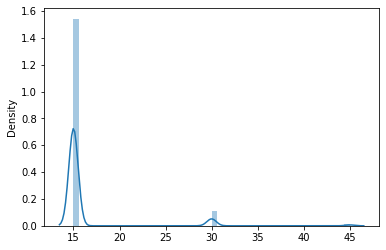

In [ ]:
sns.distplot(x=train_df['date_diff'].loc[train_df['date_diff'] > -50].loc[train_df['date_diff'] < 50])

In [ ]:
train_df = train_df.drop(columns=['date_diff', 'last_updated'])

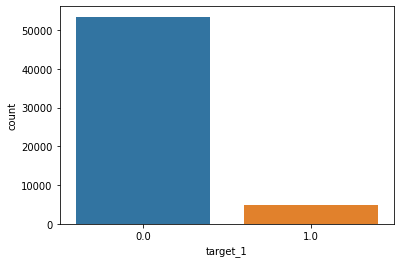

In [ ]:
sns.countplot(x=train_df['target_1'])

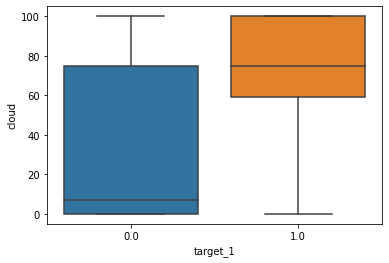

In [ ]:
sns.boxplot(y=train_df['cloud'], x=train_df['target_1'])

In [ ]:
train_df.corr()

,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target,target_1
temp_c,1.000000,0.172346,-0.186706,-0.026728,-0.043385,-0.021579,-0.404385,-0.193629,0.986906,0.221225,0.561648,-0.089234,-0.123470,-0.106580
is_day,0.172346,1.000000,0.115271,0.060677,-0.013381,-0.014837,-0.257439,0.050643,0.158804,0.028815,0.346092,-0.043763,0.022389,0.025092
wind_kph,-0.186706,0.115271,1.000000,0.142609,-0.146114,-0.005834,-0.014055,0.198766,-0.197872,-0.280653,0.052547,0.488949,0.115353,0.111822
wind_degree,-0.026728,0.060677,0.142609,1.000000,-0.187505,0.030901,-0.117513,-0.022372,-0.042778,0.032519,0.073530,0.095141,0.063563,0.056453
pressure_mb,-0.043385,-0.013381,-0.146114,-0.187505,1.000000,-0.130798,-0.052133,-0.014277,-0.046916,0.029676,-0.010062,-0.256481,-0.221866,-0.220180
precip_mm,-0.021579,-0.014837,-0.005834,0.030901,-0.130798,1.000000,0.145293,0.154561,-0.013152,-0.045008,-0.047149,0.154922,0.198835,0.165291
humidity,-0.404385,-0.257439,-0.014055,-0.117513,-0.052133,0.145293,1.000000,0.433558,-0.342081,-0.339735,-0.526439,0.025198,0.258771,0.222410
cloud,-0.193629,0.050643,0.198766,-0.022372,-0.014277,0.154561,0.433558,1.000000,-0.173766,-0.159745,-0.158238,0.256831,0.309728,0.270173
feelslike_c,0.986906,0.158804,-0.197872,-0.042778,-0.046916,-0.013152,-0.342081,-0.173766,1.000000,0.209905,0.515681,-0.098497,-0.119979,-0.102898
vis_km,0.221225,0.028815,-0.280653,0.032519,0.029676,-0.045008,-0.339735,-0.159745,0.209905,1.000000,0.128830,0.140491,-0.230749,-0.176372


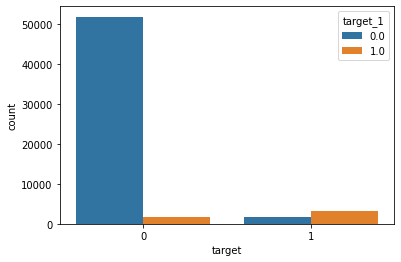

In [ ]:
sns.countplot(x=train_df['target'], hue=train_df['target_1'])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58400 entries, 0 to 58399
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         58400 non-null  object 
 1   temp_c       58400 non-null  float64
 2   is_day       58400 non-null  float64
 3   condition    58400 non-null  object 
 4   wind_kph     58400 non-null  float64
 5   wind_degree  58400 non-null  float64
 6   pressure_mb  58400 non-null  float64
 7   precip_mm    58400 non-null  float64
 8   humidity     58400 non-null  float64
 9   cloud        58400 non-null  float64
 10  feelslike_c  58400 non-null  float64
 11  vis_km       58400 non-null  float64
 12  uv           58400 non-null  float64
 13  gust_kph     58400 non-null  float64
 14  target       58400 non-null  int64  
 15  target_1     58396 non-null  float64
dtypes: float64(13), int64(1), object(2)
memory usage: 7.1+ MB


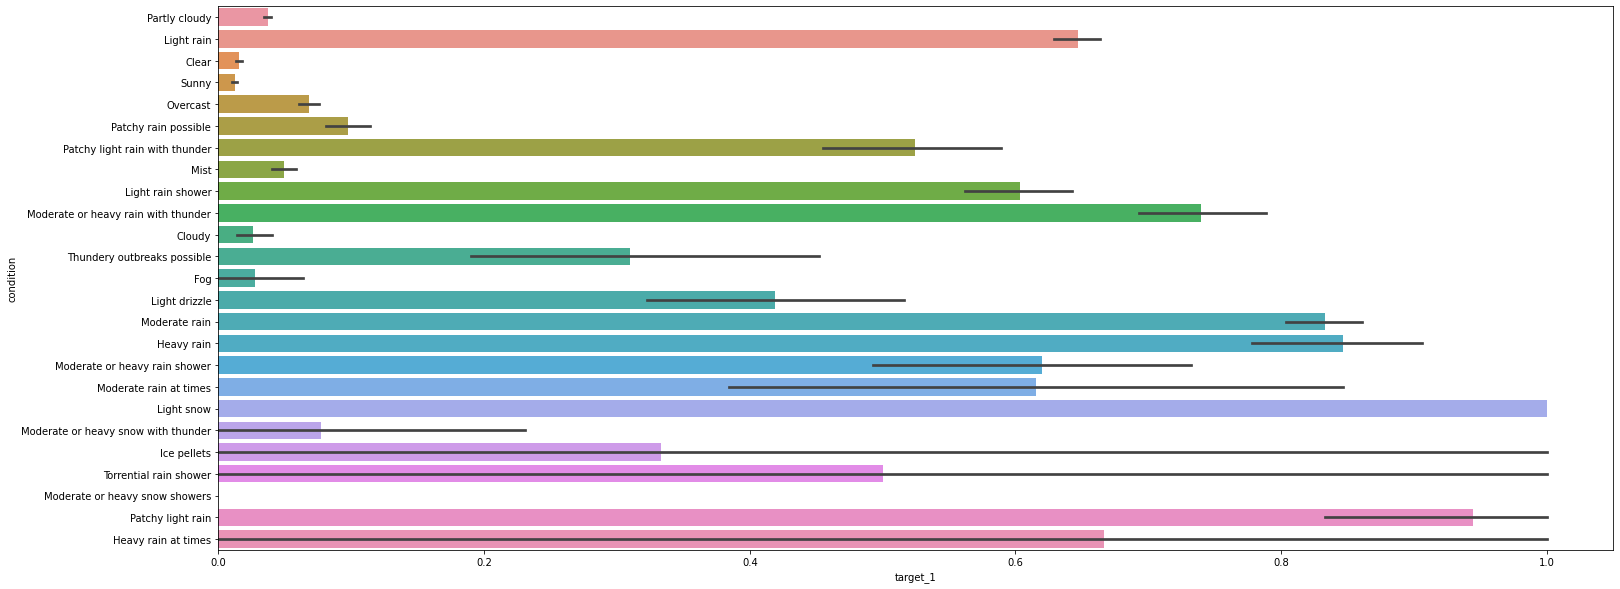

In [ ]:
plt.figure(figsize=(25, 10))
sns.barplot(y=train_df['condition'], x=train_df['target_1'], orient='horizontal')

In [ ]:
# Transform categorical variables in columns and generate X array
x = pd.get_dummies(train_df.drop(columns='target_1'), columns=['condition', 'city'])
x.head()

,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target,condition_Clear,condition_Cloudy,condition_Fog,condition_Heavy rain,condition_Heavy rain at times,condition_Ice pellets,condition_Light drizzle,condition_Light rain,condition_Light rain shower,condition_Light snow,condition_Mist,condition_Moderate or heavy rain shower,condition_Moderate or heavy rain with thunder,condition_Moderate or heavy snow showers,condition_Moderate or heavy snow with thunder,condition_Moderate rain,condition_Moderate rain at times,condition_Overcast,condition_Partly cloudy,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible,condition_Torrential rain shower,city_Beijing,city_Carapicuiba,city_Hong Kong,city_London,city_Moscow,city_New York,city_Paris,city_Rome,city_Sao Paulo
0,27.0,1.0,6.8,140.0,1013.0,1.5,70.0,25.0,31.6,10.0,5.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,18.6,1.0,6.5,2.0,1011.0,0.0,62.0,9.0,18.6,10.0,5.0,11.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,21.0,1.0,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,21.0,1.0,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,21.0,0.0,0.0,221.0,1012.0,0.3,83.0,0.0,21.0,10.0,5.0,9.7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Create Y array and clean it
y = train_df['target_1']
y = y.fillna(0.0)
y = y.astype('int')
y.unique()

array([0, 1])

In [ ]:
# Split the data between Train and Test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [ ]:
if len(x) == len(y):
  pass
else:
  raise Exception ("The data was splitted wrong")

In [ ]:
print(f'train: {x_train.shape}\ntest: {x_test.shape}')

train: (43800, 47)
test: (14600, 47)


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, max_iter=10000).fit(x_train, y_train)

In [ ]:
lr.score(x_test, y_test)

0.9434931506849316

In [ ]:
x_test['prediction'] = lr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
prob_list = []
a = lr.predict_proba(x_test.drop(columns='prediction'))
for i in a:
  prob_list.append(i[0])

In [ ]:
x_test['prob'] = prob_list
x_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,temp_c,is_day,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target,condition_Clear,condition_Cloudy,condition_Fog,condition_Heavy rain,condition_Heavy rain at times,condition_Ice pellets,condition_Light drizzle,condition_Light rain,condition_Light rain shower,condition_Light snow,condition_Mist,condition_Moderate or heavy rain shower,condition_Moderate or heavy rain with thunder,condition_Moderate or heavy snow showers,condition_Moderate or heavy snow with thunder,condition_Moderate rain,condition_Moderate rain at times,condition_Overcast,condition_Partly cloudy,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible,condition_Torrential rain shower,city_Beijing,city_Carapicuiba,city_Hong Kong,city_London,city_Moscow,city_New York,city_Paris,city_Rome,city_Sao Paulo,prediction,prob
13512,28.6,0.0,14.4,104.0,1010.0,0.0,78.0,11.0,33.2,10.0,1.0,20.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.972279
25116,12.0,0.0,0.0,104.0,1009.0,1.4,94.0,100.0,10.6,2.4,1.0,18.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.189215
18037,13.0,1.0,6.8,60.0,1013.0,0.0,82.0,0.0,12.5,10.0,1.0,15.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.979710
6179,12.0,1.0,6.8,90.0,1023.0,0.0,82.0,50.0,10.7,10.0,1.0,17.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.974781
7053,22.0,1.0,6.8,210.0,1020.0,0.0,50.0,0.0,24.2,10.0,6.0,2.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.995507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49404,17.0,0.0,9.0,60.0,1025.0,0.0,77.0,75.0,17.0,10.0,1.0,14.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.976892
55652,20.0,0.0,6.8,180.0,1016.0,0.0,43.0,0.0,20.0,10.0,8.0,6.1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.995085
6678,23.0,1.0,6.8,360.0,1018.0,0.0,41.0,0.0,25.0,10.0,5.0,7.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.996068
56661,17.9,0.0,14.0,140.0,1017.0,0.0,80.0,42.0,17.9,10.0,1.0,16.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.977255
